MCMC and Sparse MCMC in GPflow
--

*James Hensman, 2015-16*

In this notebook, we illustrate 'Exponential Regression'. The model is
$$ 
\theta \sim p(\theta)\\
f \sim \mathcal {GP}(0, k(x, x'; \theta))\\
f_i = f(x_i)\\
y_i \sim \mathcal {Exp} (e^{f_i})
$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$.

We fit two models. In the first, we do exact inference with MCMC. In the second, sparse infrence with MCMC.

In [1]:
import GPflow

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
X = np.linspace(-3,3,100)
Y = np.random.exponential(np.sin(X)**2)

In [4]:
#build the first model
k = GPflow.kernels.Matern32(1,ARD=False) + GPflow.kernels.Bias(1)
l = GPflow.likelihoods.Exponential()
m1 = GPflow.gpmc.GPMC(X[:,None], Y[:,None], k, l)

#build the second model
k = GPflow.kernels.Matern32(1,ARD=False) + GPflow.kernels.Bias(1)
l = GPflow.likelihoods.Exponential()
m2 = GPflow.sgpmc.SGPMC(X[:,None], Y[:,None], k, l, Z=X[::5,None])

for m in [m1, m2]:
    m.kern.matern32.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
    m.kern.matern32.variance.prior = GPflow.priors.Gamma(1.,1.)
    m.kern.bias.variance.prior = GPflow.priors.Gamma(1.,1.)
    


In [5]:
#Here are the two models
m1.kern

Name,values,prior,constriant
kern.matern32.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.matern32.lengthscales,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.bias.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve


In [6]:
m2.kern

Name,values,prior,constriant
kern.matern32.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.matern32.lengthscales,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.bias.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve


In [7]:
for m in [m1, m2]:
    r = m.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state


In [8]:
#Now have a look at the kernel values
m1.kern

Name,values,prior,constriant
kern.matern32.variance,[ 10.66998732],"Ga([ 1.],[ 1.])",+ve
kern.matern32.lengthscales,[ 0.04422586],"Ga([ 1.],[ 1.])",+ve
kern.bias.variance,[ 1.35419367],"Ga([ 1.],[ 1.])",+ve


In [9]:
m2.kern

Name,values,prior,constriant
kern.matern32.variance,[ 3.23145503],"Ga([ 1.],[ 1.])",+ve
kern.matern32.lengthscales,[ 0.57548758],"Ga([ 1.],[ 1.])",+ve
kern.bias.variance,[ 1.07981782],"Ga([ 1.],[ 1.])",+ve


In [10]:
# run the sampler (why is this so slow?)
samples = (m1.sample(1000, verbose=1, epsilon = 0.08),
           m2.sample(1000, verbose=1, epsilon = 0.08))

Iteration:  100 	 Acc Rate:  88.0 %
Iteration:  200 	 Acc Rate:  88.0 %
Iteration:  300 	 Acc Rate:  92.0 %
Iteration:  400 	 Acc Rate:  87.0 %
Iteration:  500 	 Acc Rate:  86.0 %
Iteration:  600 	 Acc Rate:  90.0 %
Iteration:  700 	 Acc Rate:  87.0 %
Iteration:  800 	 Acc Rate:  78.0 %
Iteration:  900 	 Acc Rate:  86.0 %
Iteration:  1000 	 Acc Rate:  92.0 %
Iteration:  100 	 Acc Rate:  84.0 %
Iteration:  200 	 Acc Rate:  91.0 %
Iteration:  300 	 Acc Rate:  91.0 %
Iteration:  400 	 Acc Rate:  85.0 %
Iteration:  500 	 Acc Rate:  94.0 %
Iteration:  600 	 Acc Rate:  92.0 %
Iteration:  700 	 Acc Rate:  81.0 %
Iteration:  800 	 Acc Rate:  87.0 %
Iteration:  900 	 Acc Rate:  88.0 %
Iteration:  1000 	 Acc Rate:  75.0 %


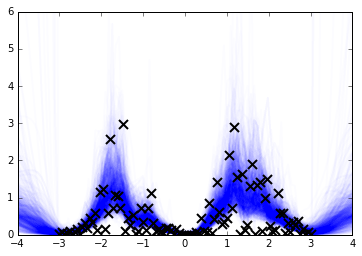

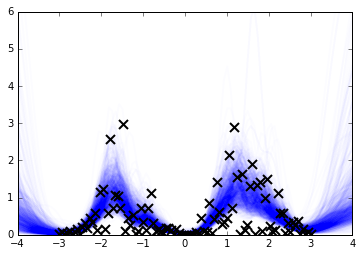

In [11]:
#make some predictions
for m, ss in zip([m1, m2], samples):
    plt.figure()
    xx = np.linspace(-4,4,100)[:,None]
    ys = []
    for s in ss:
        m.set_state(s)
        ys.append(m.predict_y(xx)[0])
        plt.plot(xx, ys[-1], 'b', alpha=0.01, lw=2)
    plt.plot(X, Y, 'kx', mew=2)
    plt.ylim(0, 6)

    
    